# Prelude
Hehe I really liked this activity.

# Acknowledgements
I'd like to thank my instructors, Sir Rene Principe Jr. and Sir Kenneth Leo, for guiding me throughout the activity. I would also like to thank my professor, Ma'am Jing, for guiding me in my coding while my classmates and I worked in R202. I would also like to acknowledge my classmates: Abdel, Johnenn, Jonabel, Richmond, Lovely, Hans, Genesis, Jeruine, Rusher, and Ron for helping me complete this activity.

# Code starts Here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import statistics as st
from PIL import Image
from skimage.measure import label, regionprops, regionprops_table
import pandas as pd
from scipy.stats import gaussian_kde

image_repository = "./Image repository/"
data_repository = "./Collected data/"

# initializing this so I have a placeholder
image = 0

> #### ${\tt thresholding(image, stdev\_mult):}$
> 1. Accepts a grayscale image
> 2. Gets the median and standard deviation of the image.
> 3. Binarizes the image by zeroing out the values that are in the range [median - ${\tt stdev\_mult}\times$(stdev), median + ${\tt stdev\_mult}\times$(stdev)] and setting the other values to $1$.
> 4. Returns the binarized image.<br>
> $~$

In [2]:
def thresholding(image, stdev_mult):

    # I'll automate the thresholding. Since we know that the highest peak in the histogram represents the image's background, 
    # my left and right borders will be np.median(image) -+ stdev_mult*stdev respectively.
    peak_ = np.median(image.flatten())
    stdev_ = np.std(image.flatten())

    # Now setting up the borders
    left_border = int(np.floor(peak_ - stdev_mult*stdev_))
    right_border = int(np.ceil(peak_ + stdev_mult*stdev_))

    # Converting to binary through. The values to the left of the left border and to the right of the right boarder are set to 1.
    T, thresholded = cv2.threshold(image, left_border, right_border, cv2.THRESH_BINARY_INV)

    return thresholded


> #### ${\tt morphing\_time(filename, filetype, commands, record = False, ROI\_size = None,}$ 
> #### ${\tt blob\_numbers = False, bounding\_box = False):}$
> 1. opens the image with the stated ${\tt filename}$.
> 2. Loops through a list of ${\tt commands}$ which contains the morphological operations along with their parameters.
> 3. Displays the original image and the final processed image.
> 4. If ${\tt record}$ is ${\tt True}$, then the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the detected objects are saved to a csv file
> 5. If ${\tt ROI\_size}$ is ${\tt True}$, then the measurements are converted to $\rm{cm}$ or whatever unit you want to set.
> 6. If ${\tt blob\_numbers}$ is ${\tt True}$, then a number is also displayed on the labelled objects.
> 6. If ${\tt bounding\_box}$ is ${\tt True}$, then the detected objects in the original image is enclosed in a box.
> $~$

In [5]:
def morphing_time(filename, filetype,commands, record = False, ROI_size = None, blob_numbers = False, bounding_box = False):
    # Setting initial parameters
    cmap_color = "gray"
    image = np.array(Image.open(image_repository + filename + filetype))
    original_image = image.copy()

    # This is where the commands are looped through
    for i in range(len(commands)):
        process = commands[i][0].lower()

        match process:
            
            case 'grayscale':       
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            case 'thresholding':
                image = thresholding(image, commands[i][1])
            case 'dilation':
                image = cv2.dilate(image, commands[i][1], iterations = commands[i][2])
            case 'erosion':
                image = cv2.erode(image, commands[i][1], commands[i][2])
            case 'opening':
                image = cv2.morphologyEx(image, cv2.MORPH_OPEN, commands[i][1])
            case 'closing':
                image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, commands[i][1])
            case 'median_blur':
                image = cv2.medianBlur(image, commands[i][1])
            case 'simple_binarize':
                # All pixels beow the boundary ares set to 0 and above are set to 1.
                boundary = np.percentile(image, commands[i][1])
                image[image < boundary] = 0
                image[image >= boundary] = 1               
                
            case other:
                print(commands[i][0] + " did nothing lol.")

    # Apply region props and save them to a csv file
    if record == True:
        image = label(image)
        regions = regionprops(image)
        props = regionprops_table(image, properties=('area','centroid', 'bbox', 'perimeter', 'eccentricity' , 'orientation',
                                                 'axis_major_length',
                                                 'axis_minor_length'))
        data = pd.DataFrame(props)

        # If an ROI_size is given, then the units of the area, axes, and perimeter are converted from pixels to a physical unit.
        if ROI_size != None:
            data.loc[:,"area"] = data.loc[:,"area"] * ROI_size/(len(original_image)*len(original_image[0]))
            data.loc[:,'axis_major_length'] = data.loc[:,'axis_major_length']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
            data.loc[:,'axis_minor_length'] = data.loc[:,'axis_minor_length']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
            data.loc[:,'perimeter'] = data.loc[:,'perimeter']* np.sqrt(ROI_size/(len(original_image)*len(original_image[0])))
        
        # Finally saving to a csv
        data.to_csv(data_repository + filename + ".csv") 
        cmap_color = "viridis"

    # Now graphing everything
    fig, ax = plt.subplots(1,2, figsize = (12,8))
    ax[0].imshow(original_image)
    ax[0].set_title(filename+filetype)

    ax[1].imshow(image, cmap = cmap_color)
    ax[1].set_title("Processed Image")
    
    # For labelling the blob numbers in the output image
    if record == True and blob_numbers == True:
        for i in range(len(data)):
            ax[1].text(data.loc[i,"centroid-1"], data.loc[i,"centroid-0"], i, fontsize = 5.5,bbox=dict(fill=True, facecolor = "white", edgecolor='white', linewidth=0.1))
    
    # For diplaying the bounding box. Source for the code is: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html
    if record == True and bounding_box == True:
        for props in regions:
            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            ax[0].plot(bx, by, '-b', linewidth=2.5)

    plt.tight_layout()
    plt.show()



# Outputs

>### Different radius coins
>
>In this part of the activity, I applied different morphological operations on coins with different radii. The coins are inside a $15~\rm{cm} \times15~\rm{cm}$ box.  The operations that I did below is my best attempt at detecting the different coins. I then applied the ${\tt regionprops}$ function from ${\tt scikit-image}$ and then got the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the coins. I then converted the units of the area, perimeter, major axis, and minor axis to $\rm{cm}^2$, $\rm{cm}$, $\rm{cm}$, and $\rm{cm}$ respectively.
<br>

So my main goal for this part is to compare the measure radii of the coins by taking the average of the major and minor axes (because the coins are circular) and then comparing that average to the actual radii of the coins that is listed by Bangko Sentral ng Pilipinas. The coins that were used are:

1. new $5$ centavo coin
2. new $25$ centavo coin
3. new $1$ peso coin
4. new $5$ peso coin
5. old $10$ centavo coin
6. old $25$ centavo coin
7. old $1$ peso coin
8. old $5$ peso coin
9. $20$ peso coin


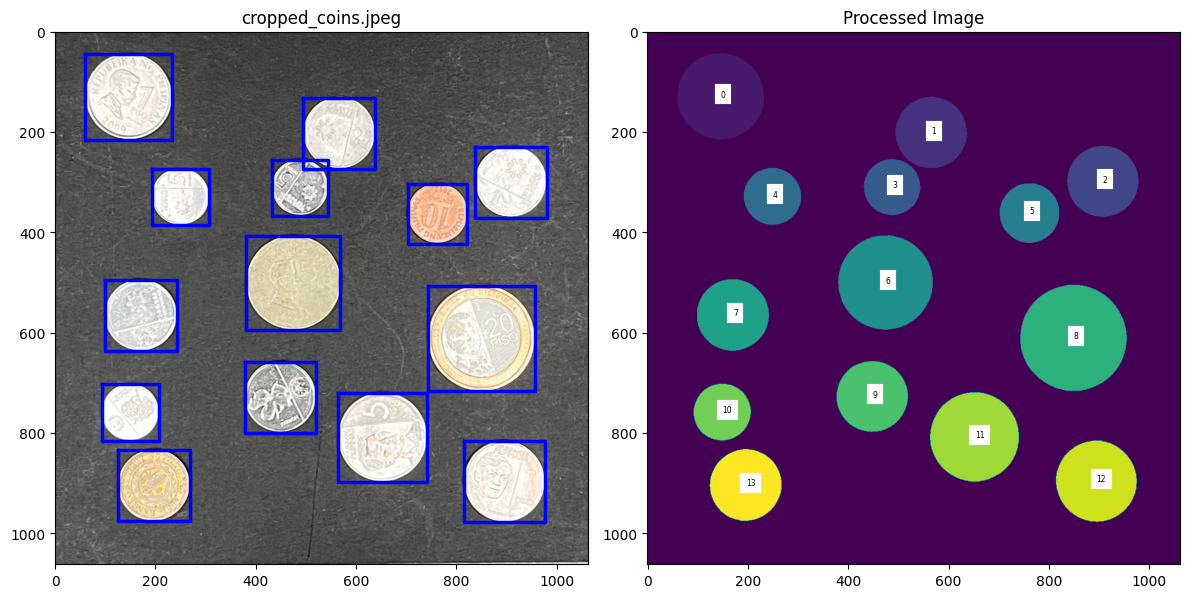

In [6]:
commands = [
            ['grayscale'],
            ['median_blur', 3],
            ['simple_binarize', 77.9],
            ["closing", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))],
            ["opening", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))],
]
morphing_time("cropped_coins", ".jpeg", commands, record = True, ROI_size = 15*15, blob_numbers = True, bounding_box = True)

#### I'll do and show the statistics in the cell below
I'll solve for the percent errors between the measured diameters, area, and perimeters with their theoretical values.

In [7]:
# Getting the data
df = pd.read_csv(data_repository + "cropped_coins.csv")
diameters = np.array([2.4, 2, 2,1.6,1.6,1.7,2.7,2,3,2,1.6,2.5,2.3,2])
measured_diameter= (df.loc[:, 'axis_major_length'] + df.loc[:, 'axis_minor_length'])/2
measured_area = df.loc[:, 'area']
measured_perimeter = df.loc[:, 'perimeter']

data= {'Coin Type': ['old 1 peso','new 25 centavo','new 25 centavo','new 5 centavo','new  5 centavo','old 10 centavo','old 5 peso','new 25 centavo','20 peso','new 25 centavo','new 5 centavo','new 5 peso','new 1 peso','old 25 centavo'],
       'Measured_diameter [cm]' : measured_diameter,
       'Measured_area [cm^2]': measured_area,
       'Measure_perimeter [cm]': measured_perimeter,
       'Theo_diameter [cm]': diameters,
       'Theo_area [cm^2]': np.pi*diameters**2/4,
       'Theo_perimeter [cm]': np.pi*diameters,
       'error_diameter [%]': abs(1 - measured_diameter/diameters)*100,
       'error_area [%]': abs(1 - measured_area/(np.pi*diameters**2/4))*100,
       'error_perimeter [%]': abs(1 - measured_perimeter/(np.pi*diameters))*100,
       }

summary = pd.DataFrame(data)
display(summary)


,Coin Type,Measured_diameter [cm],Measured_area [cm^2],Measure_perimeter [cm],Theo_diameter [cm],Theo_area [cm^2],Theo_perimeter [cm],error_diameter [%],error_area [%],error_perimeter [%]
0,old 1 peso,2.427004,4.625906,8.054476,2.4,4.523893,7.539822,1.125160,2.254967,6.825811
1,new 25 centavo,2.006447,3.161807,6.620896,2.0,3.141593,6.283185,0.322347,0.643441,5.374836
2,new 25 centavo,1.997001,3.132082,6.612622,2.0,3.141593,6.283185,0.149969,0.302730,5.243154
3,new 5 centavo,1.576168,1.951068,5.207291,1.6,2.010619,5.026548,1.489495,2.961853,3.595759
4,new 5 centavo,1.601361,2.013909,5.272062,1.6,2.010619,5.026548,0.085060,0.163608,4.884337
5,old 10 centavo,1.671337,2.193854,5.484930,1.7,2.269801,5.340708,1.686070,3.345966,2.700438
6,old 5 peso,2.649494,5.513262,8.753005,2.7,5.725553,8.482300,1.870609,3.707767,3.191411
7,new 25 centavo,2.014503,3.187143,6.629170,2.0,3.141593,6.283185,0.725141,1.449909,5.506518
8,20 peso,2.986705,7.005889,9.857296,3.0,7.068583,9.424778,0.443168,0.886944,4.589156
9,new 25 centavo,1.995417,3.127095,6.580947,2.0,3.141593,6.283185,0.229133,0.461484,4.739019


From the table, it can be seen that all the percent errors are within an acceptable range $(<10\%)$. Thus my code has successfully measured the diameters, areas, and perimeters of the coins.

>### Rice grains
>
>In this part of the activity, I applied different morphological operations on the a picture with rice grains. The rice grains are inside a $15~\rm{cm} \times15~\rm{cm}$ box. The operations that I did below is my best attempt at detecting the rice grains. I then applied the ${\tt regionprops}$ function from ${\tt scikit-image}$ and then got the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the grains. I then converted the units of the area, perimeter, major axis, and minor axis to $\rm{cm}^2$, $\rm{cm}$, $\rm{cm}$, and $\rm{cm}$ respectively.

With the extracted information, I'll get distribution of the major axis (length), area, and perimeter of the rice. I'm doing this because this was an activity in physics 106.1. Luckily for me, that was an online class and it was the instructors that did the measuring part and they just gave us the data. I'll also show the mean and the standard deviation of the histograms.

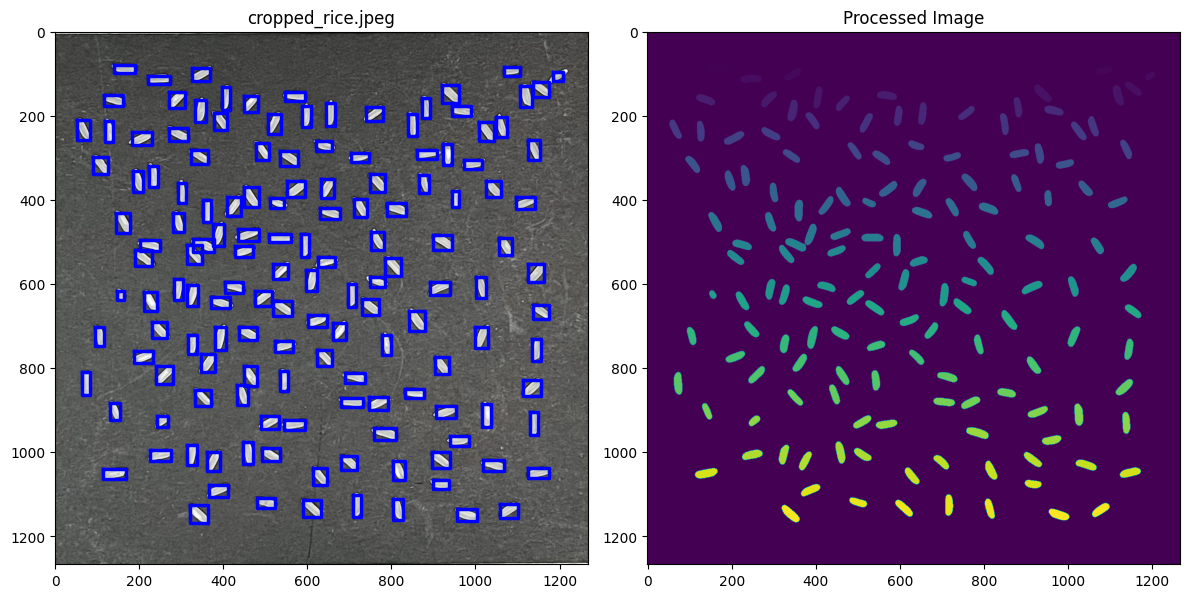

In [8]:
commands = [
            ['grayscale'],
            ['median_blur', 13],
            ['simple_binarize', 92.65],
            ["opening", cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,15))],
]
morphing_time("cropped_rice", ".jpeg", commands, record = True, ROI_size = 15*15, bounding_box = True)

#### I'll get the histogram of the area, perimeter, and major axis, and minor axis of the rice.

I will also place an overlay of the KDE to show the general distribution. The bandwidth method that I will use is the function's default method which is Scott's method
.

In [9]:
def make_KDE(data, min, max):
    positions = np.linspace(min, max, 1000)
    kernel = gaussian_kde(data)
    KDE_values = kernel(positions)
    return positions, KDE_values

Now making the histograms and plots

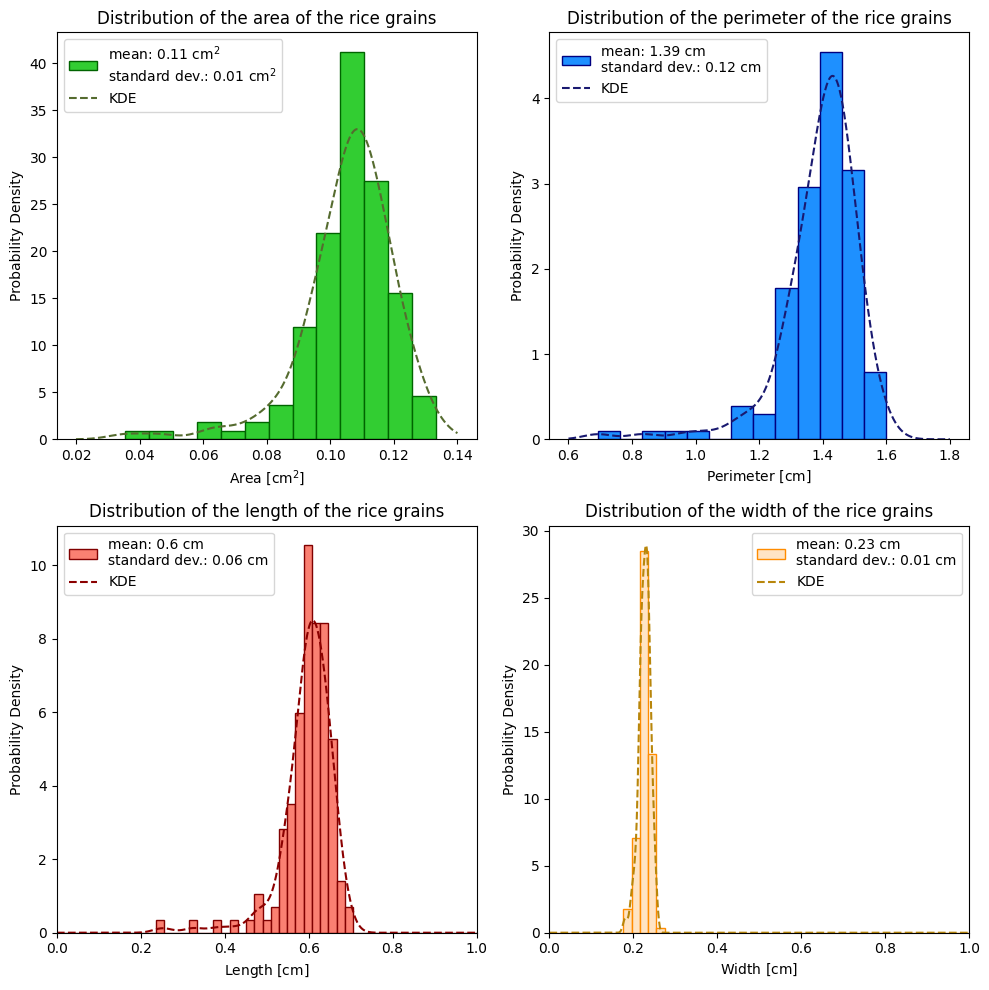

In [13]:
# Extracting data
df = pd.read_csv(data_repository + "cropped_rice.csv")

area_data = df.loc[:,'area']
perimeter_data = df.loc[:,'perimeter']
length_data = df.loc[:,'axis_major_length']
width_data = df.loc[:,'axis_minor_length']

# Getting parameters:
# Square-root choice was used to ge the number of bins for the histogram of the areas and perimeter. I multiplied this by 4 for the length and width histograms

num_bins  = np.ceil(np.sqrt(len(df))).astype(int)

area_mean = np.mean(area_data)
area_stdev = np.std(area_data)

perimeter_mean = np.mean(perimeter_data)
perimeter_stdev = np.std(perimeter_data)

length_mean = np.mean(length_data)
length_stdev = np.std(length_data)

width_mean = np.mean(width_data)
width_stdev = np.std(width_data)

# Getting KDE
positions_area, KDE_area = make_KDE(area_data, 0.02, 0.14)
positions_perimeter, KDE_perimeter = make_KDE(perimeter_data, 0.6, 1.8)
positions_length, KDE_length = make_KDE(length_data, 0, 1)
positions_width, KDE_width = make_KDE(width_data,0 ,1)

# Now plotting everything
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0,0].hist(area_data, bins = num_bins, density = True, label = "mean: " + str(np.round(area_mean,2)) + " $\mathrm{cm^2}$ \nstandard dev.: " + str(np.round(area_stdev,2)) + " $\mathrm{cm^2}$", color = "limegreen", edgecolor = "darkgreen")
ax[0,0].plot(positions_area, KDE_area, color = "darkolivegreen", label = "KDE", linestyle = "--")
ax[0,0].set_title("Distribution of the area of the rice grains")
ax[0,0].set_ylabel("Probability Density")
ax[0,0].set_xlabel("Area $[\mathrm{cm}^2]$")
ax[0,0].legend()

ax[0,1].hist(perimeter_data, bins = num_bins, density = True, label = "mean: " + str(np.round(perimeter_mean,2)) + " cm \nstandard dev.: " + str(np.round(perimeter_stdev,2)) + " cm", color = "dodgerblue", edgecolor = "navy")
ax[0,1].plot(positions_perimeter, KDE_perimeter, color = "midnightblue", label = "KDE", linestyle = "--")
ax[0,1].set_title("Distribution of the perimeter of the rice grains")
ax[0,1].set_ylabel("Probability Density")
ax[0,1].set_xlabel("Perimeter $[\mathrm{cm}]$")
ax[0,1].legend()

ax[1,0].hist(length_data, bins = np.linspace(0, 1, num_bins*4),  density = True, label = "mean: " + str(np.round(length_mean,2)) + " cm \nstandard dev.: " + str(np.round(length_stdev,2)) + " cm", color = "salmon", edgecolor = "maroon")
ax[1,0].plot(positions_length, KDE_length, color = "darkred", label = "KDE", linestyle = "--")
ax[1,0].set_title("Distribution of the length of the rice grains")
ax[1,0].set_ylabel("Probability Density")
ax[1,0].set_xlabel("Length $[\mathrm{cm}]$")
ax[1,0].set_xlim([0,1])
ax[1,0].legend()

ax[1,1].hist(width_data, bins = np.linspace(0, 1, num_bins*4), density = True, label = "mean: " + str(np.round(width_mean,2)) + " cm \nstandard dev.: " + str(np.round(width_stdev,2)) + " cm", color = "bisque", edgecolor = "darkorange")
ax[1,1].plot(positions_width, KDE_width, color = "darkgoldenrod", label = "KDE", linestyle = "--")
ax[1,1].set_title("Distribution of the width of the rice grains")
ax[1,1].set_ylabel("Probability Density")
ax[1,1].set_xlabel("Width $[\mathrm{cm}]$")
ax[1,1].set_xlim([0,1])
ax[1,1].legend()

plt.tight_layout()
plt.show()

>### Dice
>
>In this part of the activity, I applied different morphological operations on the a picture with different sided dice. The dice are inside a $15~\rm{cm} \times15~\rm{cm}$ box. The operations that I did below is my best attempt at detecting the different sided dice. I then applied the ${\tt regionprops}$ function from ${\tt scikit-image}$ and then got the area, centroid, bounding box, perimeter, eccentricity, minor axis, and major axis of the dice. I then converted the units of the area, perimeter, major axis, and minor axis to $\rm{cm}^2$, $\rm{cm}$, $\rm{cm}$, and $\rm{cm}$ respectively.

I'll look at the perimeter, area, and eccentricty of the dice. And see which ones are best to use when differentiating them.

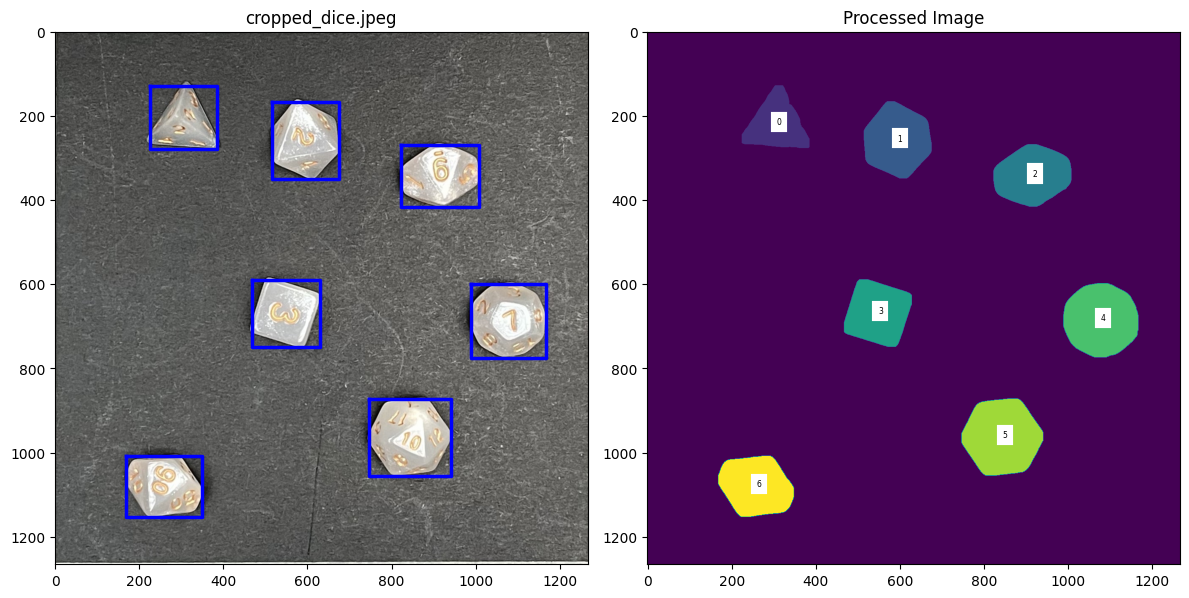

In [14]:
commands = [
            ['grayscale'],
            ['median_blur', 15],
            ['simple_binarize', 89.8],
            ["opening", cv2.getStructuringElement(cv2.MORPH_RECT,(18,20))]
]
morphing_time("cropped_dice", ".jpeg", commands, record = True, ROI_size = 15*15, blob_numbers = True, bounding_box= True)

Playing table top games is one of my favourite hobbies. And one of the games that I play is Dungeons and Dragons and we use specific types of dice to simulate probabilities such as succesfully persuading someone, the amount of damage taken, blocking an attack, sneaking through someone, and other game actions. So with this, my goal is to detect the different types of dice and determine what parameter I can use to set them apart from each other. So I'll get the standard deviation of the area, perimeter, minor axis, major axis, and eccentricity of the die.


In [17]:
# Getting the data
df = pd.read_csv(data_repository + "cropped_dice.csv")

data= {'Number of dice': [len(df)],
       'Area stdev [cm^2]' : np.std(df.loc[:,'area']),
       'Perimeter stdev [cm]': np.std(df.loc[:,'perimeter']),
       'Eccentricity stdev': np.std(df.loc[:,'eccentricity']),
       'minor axis stdev [cm]': np.std(df.loc[:,'axis_minor_length']),
       'major axis stdev [cm]': np.std(df.loc[:,'axis_major_length'])
       }

summary = pd.DataFrame(data)
display(df)
display(summary)

,Unnamed: 0,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,perimeter,eccentricity,orientation,axis_major_length,axis_minor_length
0,0,2.028677,219.777247,307.158536,129,225,278,386,6.246482,0.154859,0.687910,1.746257,1.725191
1,1,3.050948,259.257074,593.960475,167,515,350,676,6.646740,0.369301,0.042321,2.053060,1.907929
2,2,2.858483,342.585944,915.109125,269,823,417,1008,6.504067,0.674653,-1.365827,2.225544,1.642752
3,3,2.651137,669.483400,547.582896,590,468,750,629,6.545914,0.139936,1.553196,1.877042,1.858573
4,4,3.490066,686.081413,1077.558385,599,989,775,1167,6.953113,0.240544,1.304343,2.140160,2.077321
5,5,3.796102,963.944492,842.908176,873,747,1056,941,7.394027,0.168985,0.854485,2.219970,2.188044
6,6,2.842900,1080.694583,258.399486,1009,169,1154,349,6.494949,0.627484,1.204205,2.169770,1.689446


,Number of dice,Area stdev [cm^2],Perimeter stdev [cm],Eccentricity stdev,minor axis stdev [cm],major axis stdev [cm]
0,7,0.531183,0.349807,0.21008,0.189327,0.170464


It can be seen that the area of the die has the highest standard deviation. Thus the die can be differentiated based on its area.